In [ ]:
import os
os.environ['TF_PCC_MIN_LOG_LEVEL'] = '3'

In [1]:
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import numpy as np

### Compilation Strategy

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [ ]:
# to ensure no logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 2


### Reading the data

In [4]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearnin/DATASETS/CatsVsDogs/cats_vs_dogs_small/')

In [5]:
tr_d = image_dataset_from_directory(
    w_dir / 'train',
    image_size=(180,180),
    batch_size=32
)

va_d = image_dataset_from_directory(
    w_dir / 'validation',
    image_size=(180,180),
    batch_size=32
)

te_d = image_dataset_from_directory(
    w_dir / 'test',
    image_size=(180,180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Augmentation

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

### The Classifier incorporating the VGG16 model

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet'
)

conv_base.trainable = False

In [7]:
def get_model():
    inputs = keras.Input(shape=(180,180,3))
    
    x = data_augmentation(inputs)
    
    # Features straction using VGG16
    x = keras.applications.vgg16.preprocess_input(x)
    
    conv_base = keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet'
    )

    conv_base.trainable = False
    
    x = conv_base(x)
    
    # my clasifier
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

In [8]:
# to uses all the available GPUs
with strategy.scope():
    model = get_model()
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [9]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        filepath='strategy.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    
    # Monitoring the traing on TensorBoard
    keras.callbacks.TensorBoard(
        log_dir='/home/antirrabia/Documents/DeepLearnin/Notebooks/TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d,
    epochs=52,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/52
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

### Before Fine-tunning

In [10]:
# Accuracy
accuracy = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

Text(0.5, 1.0, 'Training and Validation Loss')

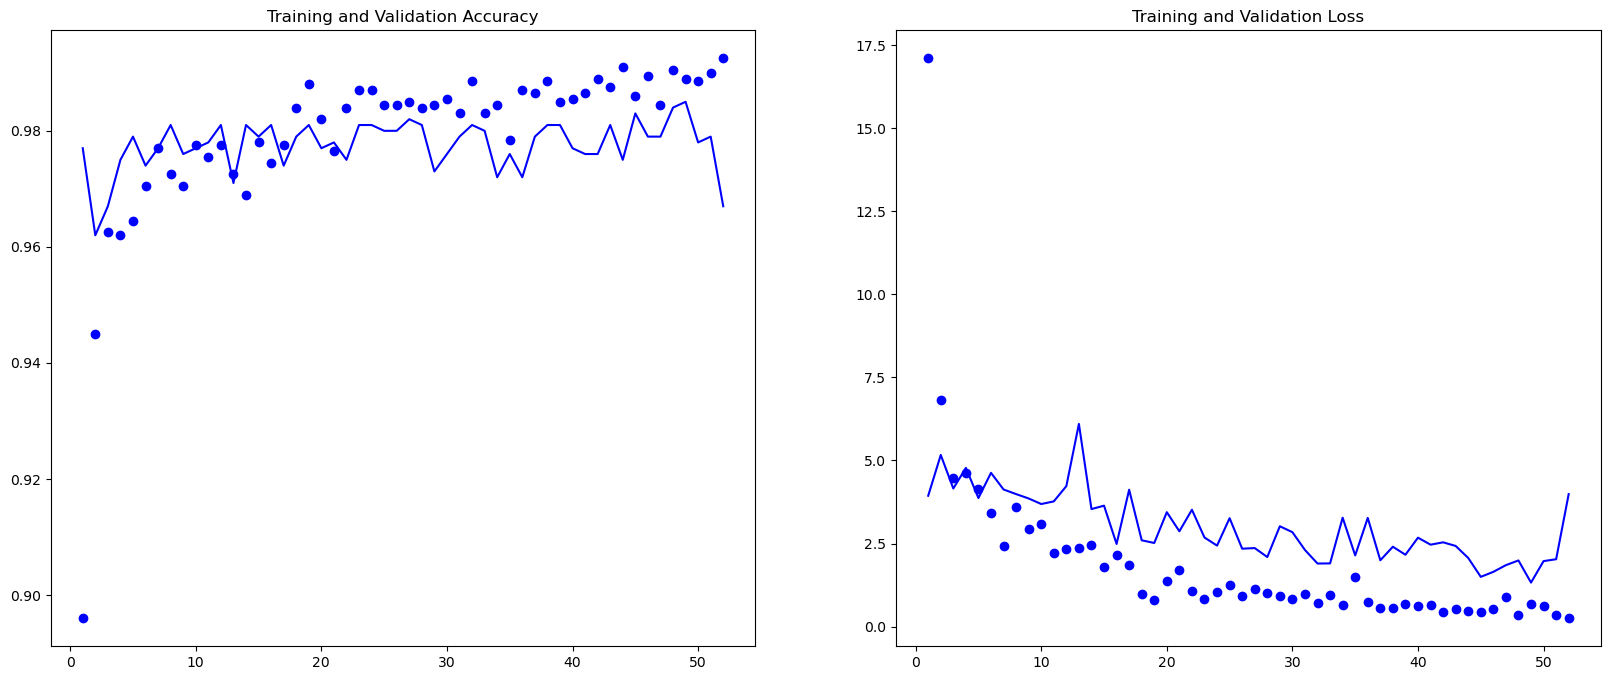

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

ax[0].plot(epochs, accuracy, 'bo', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')

ax[0].set_title('Training and Validation Accuracy')
# plt.legend(), plt.figure();

ax[1].plot(epochs, loss, 'bo', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
# plt.legend(), plt.figure();

In [12]:
# Testing the model before fine-tunning
ft_te_model = keras.models.load_model('strategy.keras')

ft_te_loss, ft_te_acc = ft_te_model.evaluate(te_d)

print(f"Before Fine-tunin test accuracy: {ft_te_acc:.3f}")

63/63 [==============================] - 10s 107ms/step - loss: 2.0095 - accuracy: 0.9790
Before Fine-tunin test accuracy: 0.979


### Fine-tunning State

In [ ]:
conv_base.trainable = True

for l in conv_base.layers[:-4]:
    l.trainable = False

NameError: name 'conv_base' is not defined

In [ ]:
with strategy.scope():
    #model = get_model()
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        filepath='strategy.keras',
        save_best_only=True,
        monitor='val_loss'
    ) 
]

history = model.fit(
    tr_d,
    epochs=25,
    validation_data=va_d,
    callbacks=callbacks
)

In [ ]:
# Accuracy
accuracy = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

ax[0].plot(epochs, accuracy, 'bo', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')

ax[0].set_title('Training and Validation Accuracy')
# plt.legend(), plt.figure();

ax[1].plot(epochs, loss, 'bo', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
# plt.legend(), plt.figure();

In [ ]:
ft_te_model = keras.models.load_model('strategy.keras')

ft_te_loss, ft_te_acc = ft_te_model.evaluate(te_d)

print(f"Fine-tunin test accuracy: {ft_te_acc:.3f}")

In [ ]:
# Accuracy
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1 )

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[].plot(epochs, accuracy, 'bo', label='Trainin Accuracy')
ax[].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[].set_title('Training and Validation Accuracy')
ax.legend(), ax[].figure();

ax[].plot(epochs, loss, 'bo', label='Training Loss')
ax[].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[].set_title('Training and Validation Loss')
ax[].legend(), ax[]
